# **Project 6: Sampling Methods**
## Amaan Rahman  & Daniel Mezhiborsky
### ECE 474 
### Professor Keene

# **Abstract**

In most situations, calculating the exact inference of probabilistic models in practical sitatuions is intractable. Methods of approximating the inference of probabilistic models are *Monte Carlo* techniques.

*Monte Carlo* techniques deal with repeatedly random sampling.

We can generate random samples of complex distributions through an indirect approach called **random sampling**. 

## *Rejection Sampling*
Given a complex target distribution we wish to sample from:

$$
p(z) = \frac{1}{Z_p}\widetilde{p}(z)
$$

$\widetilde{p}(z)$ can be evaluated, but $Z_p$ is unknown. 

We select an appropriate proposal distribtuion $q(z)$ and $kq(z) \geq \widetilde{p}(z)$. The idea is to generate a number randomly from $q(z)$ called $z_0$ and then randomly select a number, $u_0$, from a unifrom distribution that ranges from 0 to $kq(z_0)$. If $u_0$ is within $\widetilde{p}(z)$, then it is accepted; else, it is rejected. The result would be a random sampling of $p(z)$. 

The issue with this method is that a lot of samples are being unecessarily rejected to the nature of the proposal distribution, and it is severely limited in lower dimensional functions. 

We applied rejection sampling to a gaussian mixture model with a proposal function of a standard normal distribution. 

## *Markov Chain Monte Carlo (MCMC)*
A powerful random sampling technique that isn't limited by the dimensionality of the target distribution is the Markov Chain Monte Carlo (MCMC) method. 

The idea is to maintain a state space record. The proposal distribution generates a candidate state, $z^{\star}$, given the current state, $z^{(\tau)}$:

$$
\mathbf{z}^{\star} = q(\mathbf{z}|\mathbf{z}^{(\tau)})
$$

MCMC can be implemented with the basic Metropolis algorithm: 

$$
A(\mathbf{z}^{\star}, \mathbf{z}^{(\tau)}) = min\left(1,\frac{\widetilde{p}(\mathbf{z}^{\star})}{\widetilde{p}(\mathbf{z}^{(\tau)})}\right)
$$

The Metropolis algorith basically states that if the transistion from the current state to the candidate state, generated from the proposal distribution given the current state, increases the target distribution, then the candidate state is accepted; else, it is discarded and we redo the process. 

We utilize the MCMC algorithm to generate random samples of the posterior of a Bayesian linear regression problem to estimate the true weights. MCMC works well for large iterations, but can be slow as a procedure. We also attempt to use MCMC all the way to generate samples from the predictive distribution of a Bayesian linear regression problem. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import HTML
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from tqdm import trange, tqdm

%matplotlib inline
sns.set()

### *Gaussian Mixture Model*

In [ ]:
class GaussianMixtureModel(object):
    def __init__(self, K, seed):
        self.K = K
        self.rng = np.random.default_rng(seed)
        self.MU = self.rng.choice(np.linspace(-1, 1), size=K)
        self.SIG = self.rng.choice(np.linspace(0.1, 0.6), size=K)


    def _dataGen(self, N):
        X = [
             self.rng.normal(loc=m, scale=s, size=(N, 1))
             for m, s in zip(self.MU, self.SIG)
        ]
        X = np.concatenate(X, axis=1)
        np.random.shuffle(X)

        return pd.DataFrame(data=X, columns=[f'K{k}' for k in range(K)])

    
    def _pdf(self, z_space):
        in_dims = z_space.shape
        N = in_dims[0]
        pdfs = np.array([
            norm.pdf(x=z_space, loc=m, scale=s) 
            for m, s in zip(self.MU, self.SIG)
        ]).reshape(self.K, N)
        pdfs = np.sum(pdfs, axis=0).flatten()

        return pdfs

## **Rejection Sampling**

In [ ]:
# ----- GLOBALS ----- #
K = Z_p = 3
NUM_SAMPLES = 10000
SEED = 123

In [ ]:
from scipy.signal import find_peaks

def rejection_sampling(gmm : GaussianMixtureModel, num_samples: int):
    '''
    Rejection sampling function to extract random samples from 
    an arbitrary complex distribution

    Parameters
    ----------
    gmm: `GaussianMixtureModel` object
    
    num_samples: number of samples to perform rejection sampling over
    '''
    p = lambda z : gmm._pdf(z) / Z_p  # target distribution
    q = lambda z: norm.pdf(z)         # proposal distribution

    z_space = np.linspace(-5, 5, num_samples) 
    k = np.max(p(z_space)/q(z_space))

    z_0 = norm.rvs(size=NUM_SAMPLES)
    u_0 = np.random.uniform(low=0., high=(k * q(z_0))) 
    a_ind = np.where(u_0 <= p(z_0)) # indicies of accepted points
    r_ind = np.where(u_0 > p(z_0))  # indicies of rejected points
    a = u_0[a_ind]
    r = u_0[r_ind]

    accepted = (z_0[a_ind], u_0[a_ind])
    rejected = (z_0[r_ind], u_0[r_ind])

    return accepted, rejected

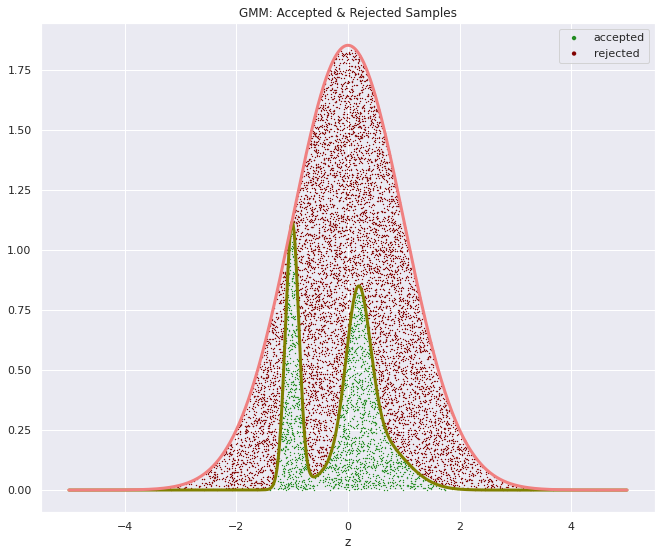

In [ ]:
# init GaussianMixtureModel
GMM = GaussianMixtureModel(K, SEED)
df_x = GMM._dataGen(NUM_SAMPLES)
GMM._dataGen(NUM_SAMPLES)

# init target and proposal pdfs
z_space = np.linspace(-5, 5, NUM_SAMPLES)
p = lambda z : GMM._pdf(z) / Z_p
q = lambda z: norm.pdf(z)
k = np.max(p(z_space)/q(z_space))

# rejection sampling
accepted, rejected = rejection_sampling(GMM, NUM_SAMPLES)

# plot pdfs, accepted & rejected samples
fig = plt.figure(figsize=(11, 9))
ax = plt.gca()
sns.lineplot(x=z_space, y=p(z_space), color='olive', linewidth=3)
sns.lineplot(x=z_space, y=k * q(z_space), color='lightcoral', linewidth=3)
sns.scatterplot(x=accepted[0], y=accepted[1], color='forestgreen', s=2, label='accepted')
sns.scatterplot(x=rejected[0], y=rejected[1], color='maroon', s=2, label='rejected')
plt.xlabel('z')
l = plt.legend()
for lh in l.legendHandles: 
    lh.set_sizes((20, 20))

plt.title("GMM: Accepted & Rejected Samples")
plt.show()

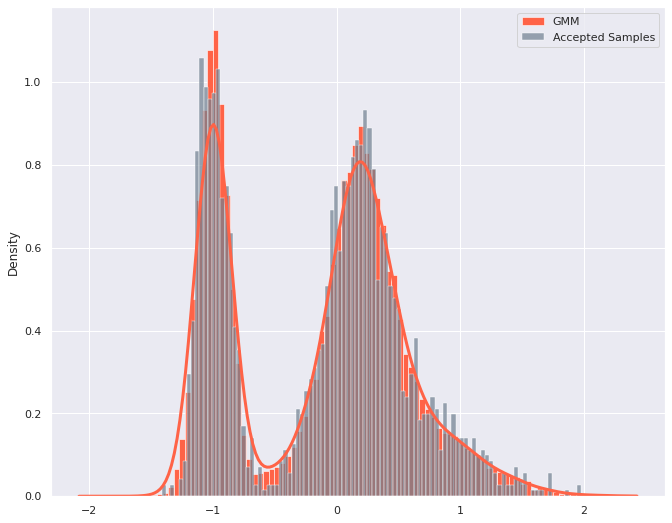

In [ ]:
plt.figure(figsize=(11, 9))
sns.histplot(x=(df_x.to_numpy().flatten()), kde=True, bins=100, stat='density', color='tomato', label='GMM', alpha=1, line_kws={'linewidth':3})
sns.histplot(x=accepted[0], kde=False, bins=100, stat='density', color='slategrey', label='Accepted Samples', alpha=0.7)
plt.legend()
plt.show()

## **Markov Chain Monte Carlo**

### *Project 2: Linear Regression Reused Code*

In [ ]:
A_0, A_1 = (-0.3, 0.5)

class Data(object):
    '''
    Sample data generator

    Parameters
    ----------
    fn_type: function to generate data from (LINEAR/SIN)
    x_rng: range of input data
    num_samples: size of sample data
    epsilon: noise factor
    '''
    def __init__(self, fn_type, x_rng, num_samples, epsilon):
        noise = np.random.normal(0, epsilon, size=(num_samples, 1)) # gaussian noise

        self.indicies = np.arange(num_samples)
        self.x = np.linspace(x_rng[0], x_rng[1], num_samples)
        self.x = np.atleast_2d(self.x).T
        if fn_type == 'LINEAR':
            self.t = (A_0 + A_1 * self.x) + noise
            self.t_Truth = A_0 + A_1 * self.x
            
        elif fn_type == 'SIN':
            self.t = 1 * np.sin(2 * np.pi * self.x) + noise
            self.t_Truth = 1 * np.sin(2 * np.pi * self.x)

    def _getBatch(self, batch_size):
        '''
        Get random batch of random sample dataset

        Parameters
        ----------
        batch_size: # of samples in a batch 
        
        Return
        ------
        Random batch of input data and target data
        '''
        batch_ind = np.random.choice(self.indicies, size=batch_size)
        return (
            self.x[batch_ind],
            self.t[batch_ind].flatten()
        )


In [ ]:
class DesignMatrix(object):
    '''
    Design matrix object class

    Parameter
    ---------
    basis_type: type of basis functions to be in design matrix
    '''
    def __init__(self, basis_type):
        self.basis_type = basis_type
        self.basis_fn = {
            'LINEAR': self.__identity,
            'GAUSSIAN': self.__gaussian
        }


    def __call__(self, x, **kwargs):
        '''
        Object call method to construct design matrix of a given basis type

        Parameters
        ----------
        x: input data
        kwargs: configuartion args for non-linear basis functions in design matrix

        Return
        ------
        Composed design matrix with appropriate basis functions
        '''
        basis = self.basis_fn[self.basis_type]
        if self.basis_type == 'LINEAR':
            PHI = np.array([np.ones(x.shape[0]), basis(x)]).T
        else:
            params = list(kwargs.values())
            assert all(p.shape == params[0].shape for p in params), \
                   "[ERROR]: Specified parameters don't have same shapes"
            PHI = np.concatenate([[np.ones(x.shape[0])] + [basis(x, *p) for p in zip(*params)]], axis=1).T

        return PHI


    def __identity(self, x):
        '''
        Identity basis function where phi(x) = x

        Parameter
        ---------
        x: input data

        Return
        ------
        Flattened input data 
        '''
        return x.flatten()


    def __gaussian(self, x, mu, s = 0.1):
        '''
        Gaussian basis function 

        Parameters
        ----------
        x: input data

        mu: mean of gaussian basis function

        s: standard deviation of gaussian basis function

        Return
        ------
        Flattened gaussian basis function
        '''
        return np.exp(-0.5 * ((x - mu) ** 2) / (s ** 2)).flatten()

### *Model Class with MCMC*

In [ ]:
class Model(object):
    def __init__(self, basis_type, alpha, beta, num_basis, num_itr, M):
        self.make_DM = DesignMatrix(basis_type)
        self.alpha = alpha
        self.beta = beta
        self.num_basis = num_basis
        self.num_iterations = num_itr
        self.M = M


    def _MCMC(self, distr_type, x, t, z_0, **kwargs):
        '''
        Monte Carlo Markov Chain (Metropolis) Algorithm

        Parameters
        ----------
        distr_type:   type of target distribution to sample
        x:            input data
        t:            target data
        z_0:          initial state 

        Return
        ------
        Sampled results from a distribution with MCMC
        '''
        self.x, self.t = x, t   
        self.PHI = self.make_DM(x, **kwargs)  # design matrix
        D = z_0.shape[0]

        if distr_type == 'POSTERIOR':
            p = self.__posterior
        # in the future more options could be added to apply MCMC to

        # initialize record of results
        res = np.zeros(shape=(self.num_iterations, D)) # D: # of features to sample
        res[0] = z_0 

        for epoch in trange(1, self.num_iterations, position=0, leave=True):
            self.z_tau = res[epoch - 1][None, ...]   # get previous state
            self.z_star = self.__q()                 # get next candidate state
            if self.__metropolis(p=p):
                res[epoch] = self.z_star          # accept candidate state when A > u
            else:
                res[epoch] = self.z_tau           # discard candidate state 

        return res


    def _predict(self, train, test, **kwargs):
        '''
        Sample predictive distribution

        Parameters
        ----------
        train:  training data
        test:   test data
        kwargs: positional arguments for design matrix

        Return
        ------
        Sampled target predictions
        '''
        x_train, t_train = train
        x_test, t_test = test

        w_0 = norm.rvs(size=self.num_basis)

        # draw independent weight samples from the posterior
        w = self._MCMC('POSTERIOR', x_train, t_train, z_0=w_0, **kwargs)[self.M:, :]
        
        PHI_pred = self.make_DM(x_test, **kwargs)
        t_pred = np.zeros(shape=(self.M, t_test.shape[0]))
        for epoch in trange(self.M):
            mu = w[epoch][None, ...] @ PHI_pred.T
            std = 1 / np.sqrt(self.beta)
            t_pred[epoch] = norm.rvs(loc=mu, scale=std)

        return t_pred


    def __metropolis(self, p):
        '''
        Metropolis algorithm

        Parameters
        ----------
        p:          target distribution to generate samples for

        Return
        ------
        Whether the candidate state is accepted or rejected
        '''
        u = np.random.uniform(low=0.0, high=1.0)
        A = np.exp(p(self.z_star) - p(self.z_tau))

        return A > u


    def __posterior(self, z):
        '''
        Posterior distribution
        
        Parameters
        ----------
        z:  given state

        Return
        ------
        Log of posterior distribution => sum of likelihood and prior
        '''
        return self.__likelihood(z) + self.__prior(z)


    def __q(self):
        '''
        Proposal distribution centered at current state

        Return
        ------
        Candidate state from proposal distribution
        '''
        z_star = norm.rvs(loc=self.z_tau)[None, ...]

        return z_star


    def __likelihood(self, z):
        '''
        Likelihood distribution
        
        Parameters
        ----------
        z:  given state

        Return
        ------
        Log of likelihood distribution
        '''
        mu = z @ self.PHI.T    # (D, NUM_BASIS) @ (BATCH_SIZE, NUM_BASIS).T
        std = 1 / (np.sqrt(self.beta))

        return np.sum(norm.logpdf(x=self.t, loc=mu, scale=std))


    def __prior(self, z):
        '''
        Prior distribution

        Parameters
        ----------
        z:  given state

        Return
        ------
        Log of prior distribution
        '''
        M = np.zeros(shape=self.num_basis)
        S = 1 / self.alpha * np.eye(N=self.num_basis)

        return np.sum(multivariate_normal.logpdf(x=z, mean=M, cov=S))


### *MCMC Sampling Posterior*

In [ ]:
# === GLOBALS === #
M = 10000               # (for MCMC) samples after a large M imply independence
TYPE = 'LINEAR'
NUM_BASIS = 2
NUM_SAMPLES = 100
NUM_ITER = 50000
BATCH_SIZE = 25
BETA = 25
ALPHA = 2.0
A_0, A_1 = (-0.3, 0.5)

In [ ]:
# === DATA GEN === #
noise_std = 1 / BETA
DataGen = Data(TYPE, (-1, 1), NUM_SAMPLES, noise_std)
x, t = DataGen._getBatch(BATCH_SIZE)

# init model
model = Model(TYPE, ALPHA, BETA, NUM_BASIS, NUM_ITER, M)

In [ ]:
w = model._MCMC('POSTERIOR', x, t, z_0 = norm.rvs(size=2))
a0_pred, a1_pred = np.mean(w[M:, :], axis=0)

100%|██████████| 49999/49999 [00:45<00:00, 1089.99it/s]


In [ ]:
print(f'=== PREDICTED RESULTS ===\n')
print(f'a_0: {a0_pred:.3f} | Error: {np.abs((np.abs(a0_pred - A_0) / A_0) * 100):.3f} %')
print(f'a_1: {a1_pred:.3f}  | Error: {np.abs((np.abs(a1_pred - A_1) / A_1) * 100):.3f} %')

=== PREDICTED RESULTS ===

a_0: -0.302 | Error: 0.758 %
a_1: 0.491  | Error: 1.829 %


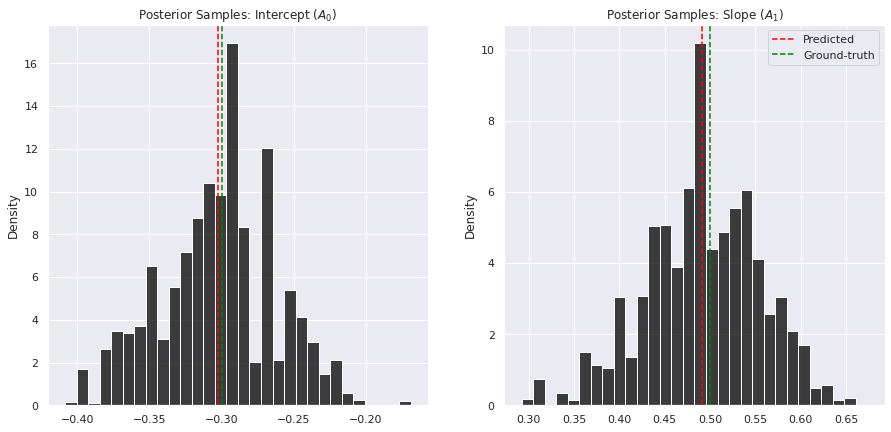

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121)
sns.histplot(x=w[M:, 0], bins=30, stat='density', color='black', ax = ax)
ax.axvline(x=a0_pred, color='red', linestyle='--')
ax.axvline(x=A_0, color='green', linestyle='--')
ax.set_title('Posterior Samples: Intercept ($A_0$)')

ax = fig.add_subplot(122)
sns.histplot(x=w[M:, 1], bins=30, stat='density', color='black', ax = ax)
ax.axvline(x=a1_pred, color='red', linestyle='--', label='Predicted')
ax.axvline(x=A_1, color='green', linestyle='--', label='Ground-truth')
ax.set_title('Posterior Samples: Slope ($A_1$)')
ax.legend()
plt.show()

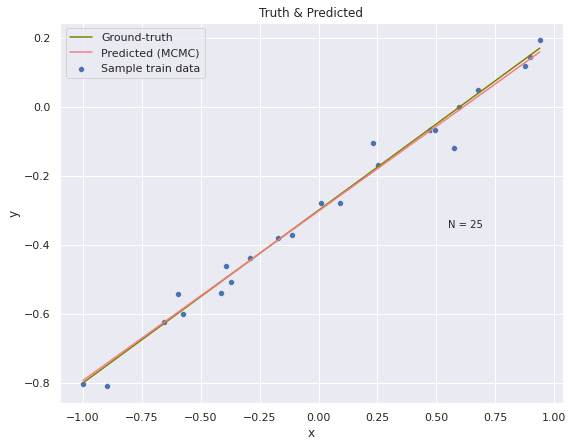

In [ ]:
plt.figure(figsize=(9, 7))
sns.scatterplot(x=x.flatten(), y=t.flatten(), label='Sample train data')
sns.lineplot(x=x.flatten(), y=(A_0 + A_1 * x.flatten()), color='olive', label='Ground-truth')
sns.lineplot(x=x.flatten(), y=(a0_pred + a1_pred * x.flatten()), color='lightcoral', label='Predicted (MCMC)')
plt.text(0.55, -0.35, f'N = {BATCH_SIZE}')
plt.legend(), plt.xlabel('x'), plt.ylabel('y'), plt.title('Truth & Predicted')
plt.show()

## **MCMC for Predictive Distribution**

Epoch 1:


100%|██████████| 1000/1000 [00:00<00:00, 12803.99it/s]


Epoch 2:


100%|██████████| 1000/1000 [00:00<00:00, 12445.23it/s]


Epoch 3:


100%|██████████| 1000/1000 [00:00<00:00, 11010.15it/s]


Epoch 4:


100%|██████████| 1000/1000 [00:00<00:00, 11713.94it/s]


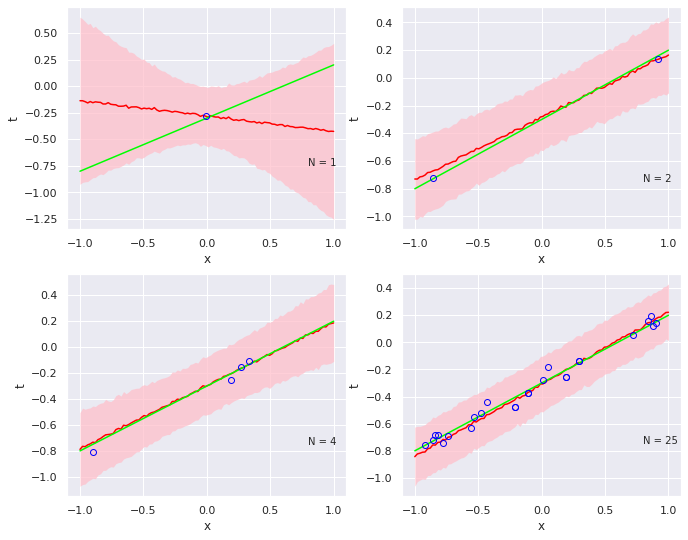

In [ ]:
BATCH_SIZE = [1, 2, 4, 25]

# change MCMC iterations and M
model.num_iterations = 5000
model.M = 1000

# generate data
train = DataGen._getBatch(25)
test = (DataGen.x, DataGen.t_Truth)
x_test, t_test = test

# predict and plot for each batch size
fig = plt.figure(figsize=(11, 9))
plt_shape = [2, 2, 1]
for batch in BATCH_SIZE:
    print(f'Epoch {plt_shape[2]}:')
    train = DataGen._getBatch(batch)
    x_train, t_train = train
    t_pred = model._predict(train, test)
    mu = np.mean(t_pred, axis=0)
    sigma = np.std(t_pred, axis=0)

    ax = fig.add_subplot(*plt_shape)
    ax.fill_between(x_test.flatten(), mu + sigma, mu - sigma, alpha=0.75, color='pink', lw=0)
    ax.plot(x_test.flatten(), mu, color='red')
    ax.plot(x_test.flatten(), t_test, color='lime')
    ax.plot(x_train.flatten(), t_train.flatten(), 'o', color='blue', mfc='none')

    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.text(0.8, -0.75, f'N = {x_train.shape[0]}')

    plt_shape[2] += 1

plt.show()